In [1]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [2]:
source("../../../src/Variacion/functions.R")
source("../../../src/general.R")

# Data variables

In [3]:
municipio = "Santander"
site = "" # c("es1580a", "es0118a")

data.by.file = TRUE

pollutant = c("no2")#, "no", "o3", "pm10", "pm2.5")
start_dt = 2015

# Lockdown dates

In [4]:
periods <- list(
    # lockdown
    lockdown = as.numeric(ymd_hms("2020-03-14 00:00:00")),
    #end.lockdown = as.numeric(ymd_hms("2020-04-28 00:00:00")),

    # poslockdown
    fases = as.numeric(ymd_hms("2020-05-01 00:00:00")),
    normalidad = as.numeric(ymd_hms("2020-06-21 00:00:00")),

    # New lockdown
    new.lockdown = as.numeric(ymd_hms("2020-10-25 00:00:00"))
)

---

In [5]:
if (site == "" && municipio != "") {
    site <- get.site.municipio(municipio,
                               fileName="../../../data/curation/sitesAQ.csv")
}

In [6]:
data.AQ <- get.AQdata(site, pollutant, start_dt, data.by.file)
head(data.AQ)

date,date_end,site,variable,process,summary,validity,unit,value
<dttm>,<dttm>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<dbl>
2015-01-01 00:00:00,2015-01-01 01:00:00,es1580a,no2,118046,1,1,ug.m-3,42.75
2015-01-01 01:00:00,2015-01-01 02:00:00,es1580a,no2,118046,1,1,ug.m-3,37.75
2015-01-01 02:00:00,2015-01-01 03:00:00,es1580a,no2,118046,1,1,ug.m-3,39.00
2015-01-01 03:00:00,2015-01-01 04:00:00,es1580a,no2,118046,1,1,ug.m-3,29.50
2015-01-01 04:00:00,2015-01-01 05:00:00,es1580a,no2,118046,1,1,ug.m-3,34.50
2015-01-01 05:00:00,2015-01-01 06:00:00,es1580a,no2,118046,1,1,ug.m-3,37.75


# Calculo Propio de Media diaria

In [7]:
data.AQ.dy <- data.AQ %>%
                group.dy(unit="day", FUN=mean)

# Comparar Datos por Año

In [8]:
data.all <- compare.years(data.AQ.dy, last.yr=2020)

# Variaciones diarias

In [9]:
# Calcular variaciones
var.med <- get.difference(data.all, "2020",c("2019", 
                                             paste(start_dt, "-2019", sep="")))
var.med[,4:ncol(var.med)] <- var.med[,4:ncol(var.med)]*100

In [10]:
head(var.med)

,date,variable,site,2019.vs.2020,2015-2019.vs.2020
,<dttm>,<chr>,<chr>,<dbl>,<dbl>
1,2020-01-01,no2,es1580a,46.80493,-10.51049
2,2020-01-02,no2,es1580a,NA,-20.79280
3,2020-01-03,no2,es1580a,NA,11.35465
4,2020-01-04,no2,es1580a,50.80100,-11.23963
5,2020-01-05,no2,es1580a,-16.68667,-33.89217
6,2020-01-06,no2,es1580a,13.02876,-13.47150


# Obtain Breakpoints from Variations

In [11]:
#```R
var <- data.frame(y.1=var.med$"2015-2019.vs.2020",
                  y.2=var.med$"2019.vs.2020",
                  x=as.numeric(var.med$date)
                 )
#``` 

In [12]:
fil.1 <- filter.by.std(var.med, c("2015-2019.vs.2020",
                                  "2019.vs.2020"), 5)

var <- data.frame(y.1=fil.1$"2015-2019.vs.2020",
                  y.2=fil.1$"2019.vs.2020",
                  x=as.numeric(fil.1$date)
                  
                 )

## Using `segmented` package

In [13]:
suppressMessages(library(segmented))

my.seg.1 <- segmented(lm(y.1 ~ x + 1, data=var), 
                      seg.Z = ~ x,
                      psi = list(x = periods)
                     )

my.seg.2 <- segmented(lm(y.2 ~ x + 1, data=var), 
                      seg.Z = ~ x,
                      psi = list(x = periods)
                     )

Warning message:
"No breakpoint estimated"


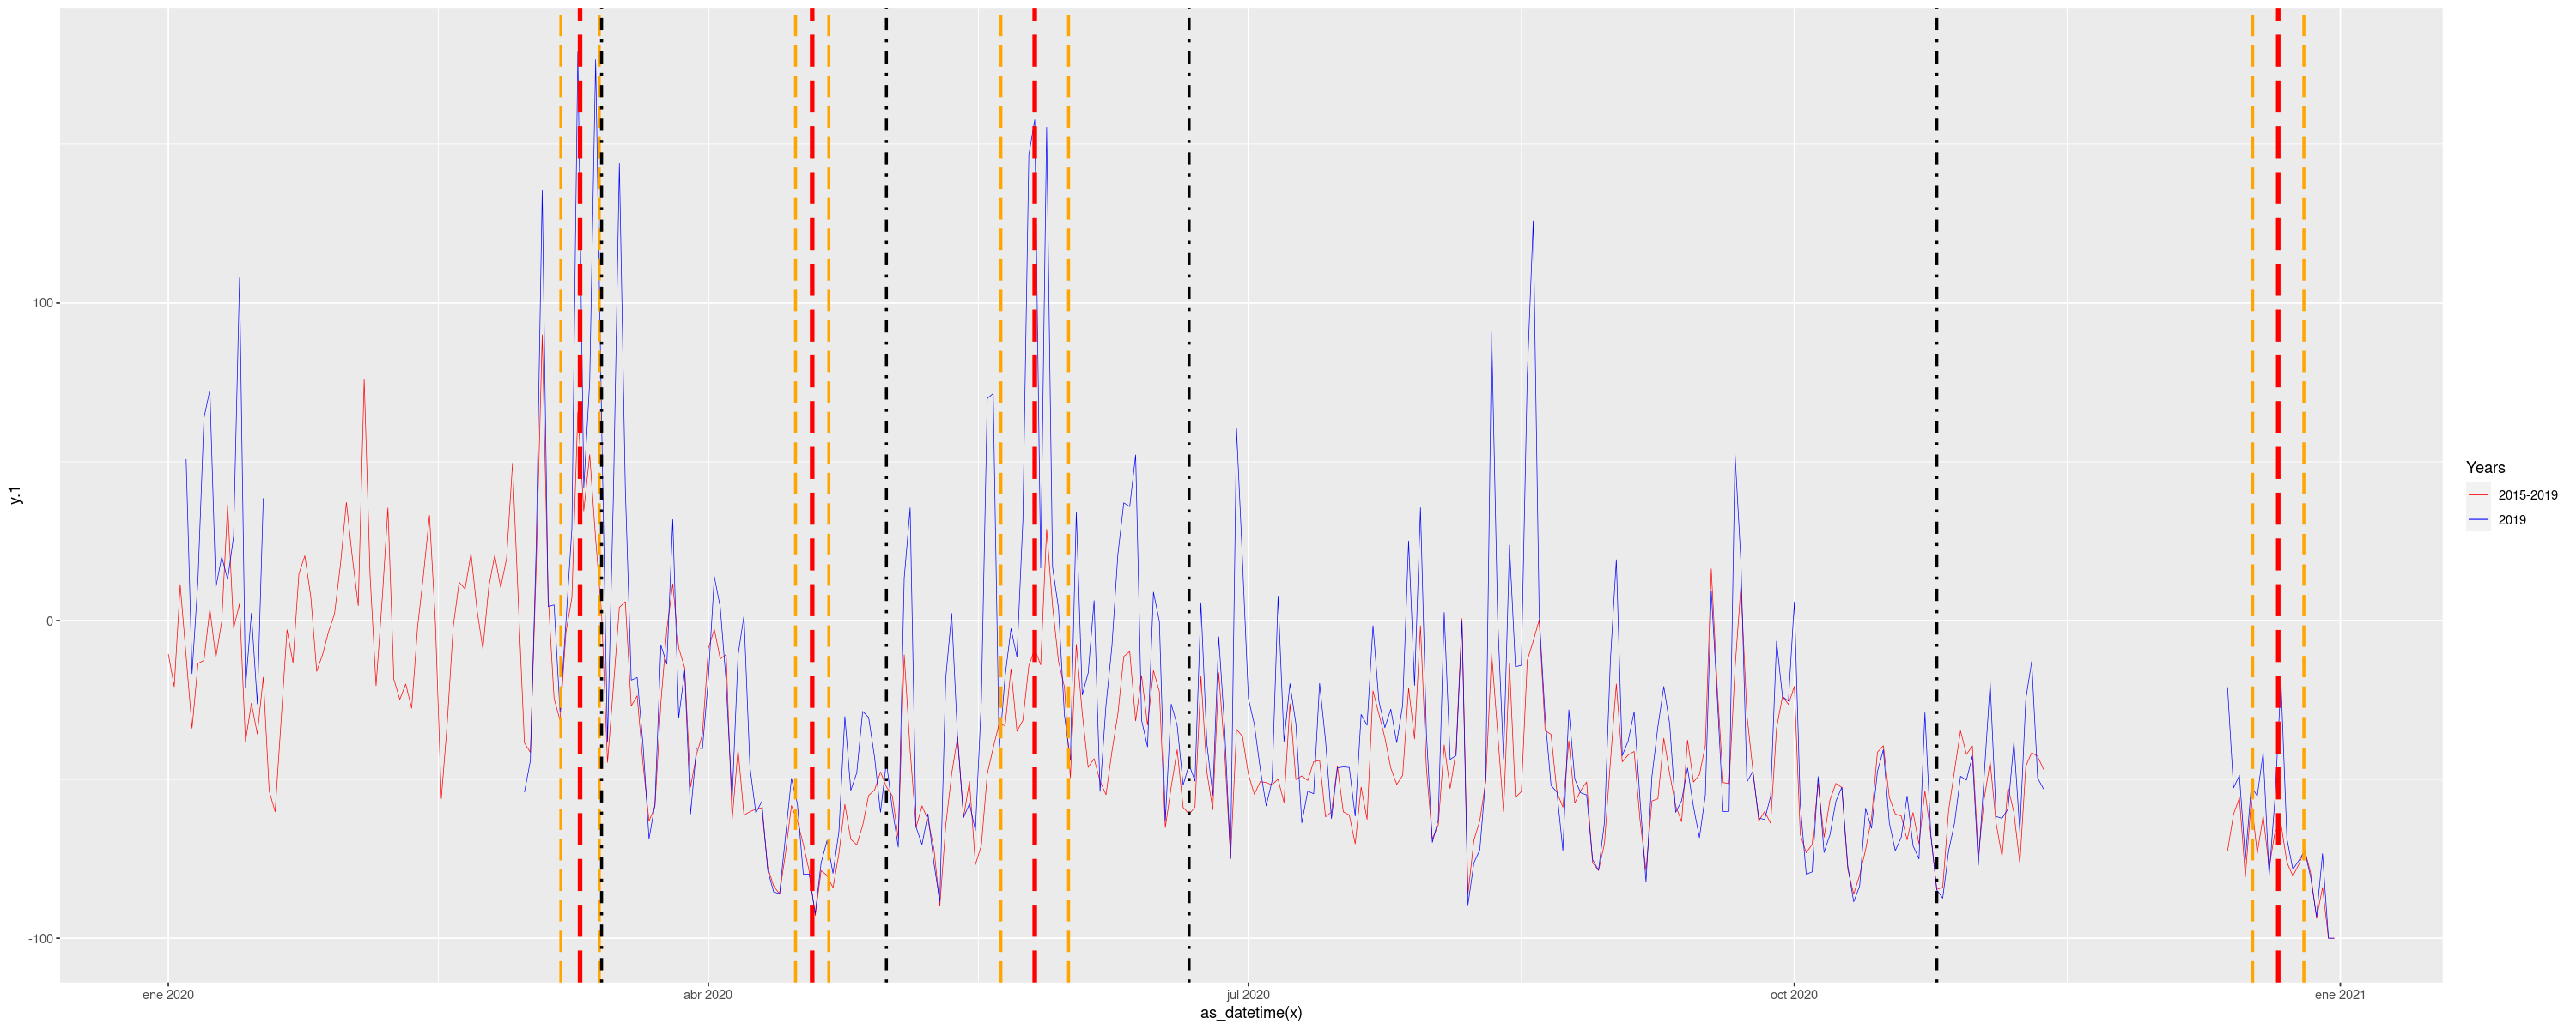

In [14]:
plot <- ggplot(data=var, aes(x=as_datetime(x)))+ 
    scale_color_manual(name = "Years", 
                       values = c("2015-2019" = "red",
                                  "2019" = "blue"))


plot <- plot + geom_line(aes(y=y.1, color="2015-2019"), size=0.2)
plot <- plot + geom_line(aes(y=y.2, color="2019"), size=0.2)

if (length(my.seg.1$psi) != 0) {
    for (k in 1:(nrow(my.seg.1$psi))) {
        plot <- plot + geom_vline(xintercept = my.seg.1$psi[k,"Est."], 
                                  linetype=5, color = "red", size=1.5)
        plot <- plot + geom_vline(xintercept = my.seg.1$psi[k,"Est."] - my.seg.1$psi[k,"St.Err"], 
                                  linetype=5, color = "orange", size=1)
        plot <- plot + geom_vline(xintercept = my.seg.1$psi[k,"Est."] + my.seg.1$psi[k,"St.Err"], 
                                  linetype=5, color = "orange", size=1)
    }
}

if (length(my.seg.2$psi) != 0) {
    for (k in 1:(nrow(my.seg.2$psi))) {
        plot <- plot + geom_vline(xintercept = my.seg.2$psi[k,"Est."], 
                                  linetype=5, color = "blue", size=1.5)
        plot <- plot + geom_vline(xintercept = my.seg.2$psi[k,"Est."] - my.seg.2$psi[k,"St.Err"], 
                                  linetype=5, color = "lightblue", size=1)
        plot <- plot + geom_vline(xintercept = my.seg.2$psi[k,"Est."] + my.seg.2$psi[k,"St.Err"], 
                                  linetype=5, color = "lightblue", size=1)
    }
}

for (k in 1:(length(periods))) {
    plot <- plot + geom_vline(xintercept = as.numeric(periods[k]), 
                              linetype=4, color = "black", size=1)
}

plot +
  ylim(min(var$y.2), max(var$y.2))

In [15]:
as_datetime(my.seg.1$psi[,"Est."])
as_datetime(my.seg.1$psi[,"St.Err"])-as_datetime(0)

                   psi1.x                    psi2.x                    psi3.x 
"2020-03-10 08:57:20 UTC" "2020-04-18 11:50:26 UTC" "2020-05-25 23:50:22 UTC" 
                   psi4.x 
"2020-12-21 13:01:37 UTC" 

Time differences in days
  psi1.x   psi2.x   psi3.x   psi4.x 
3.226988 2.803434 5.702123 4.313186 

## Using `strucchange` package

In [16]:
suppressMessages(library(strucchange))

my.other.seg.1 <- breakpoints(y.1 ~ x + 1, 
                            h = 0.15, 
                            breaks = 5,
                            data = var)
new.breaks.1 <- as_datetime(my.other.seg.1$breakpoints)

my.other.seg.2 <- breakpoints(y.2 ~ x + 1, 
                            h = 0.15, 
                            breaks = 5,
                            data = var)
new.breaks.2 <- as_datetime(my.other.seg.2$breakpoints)

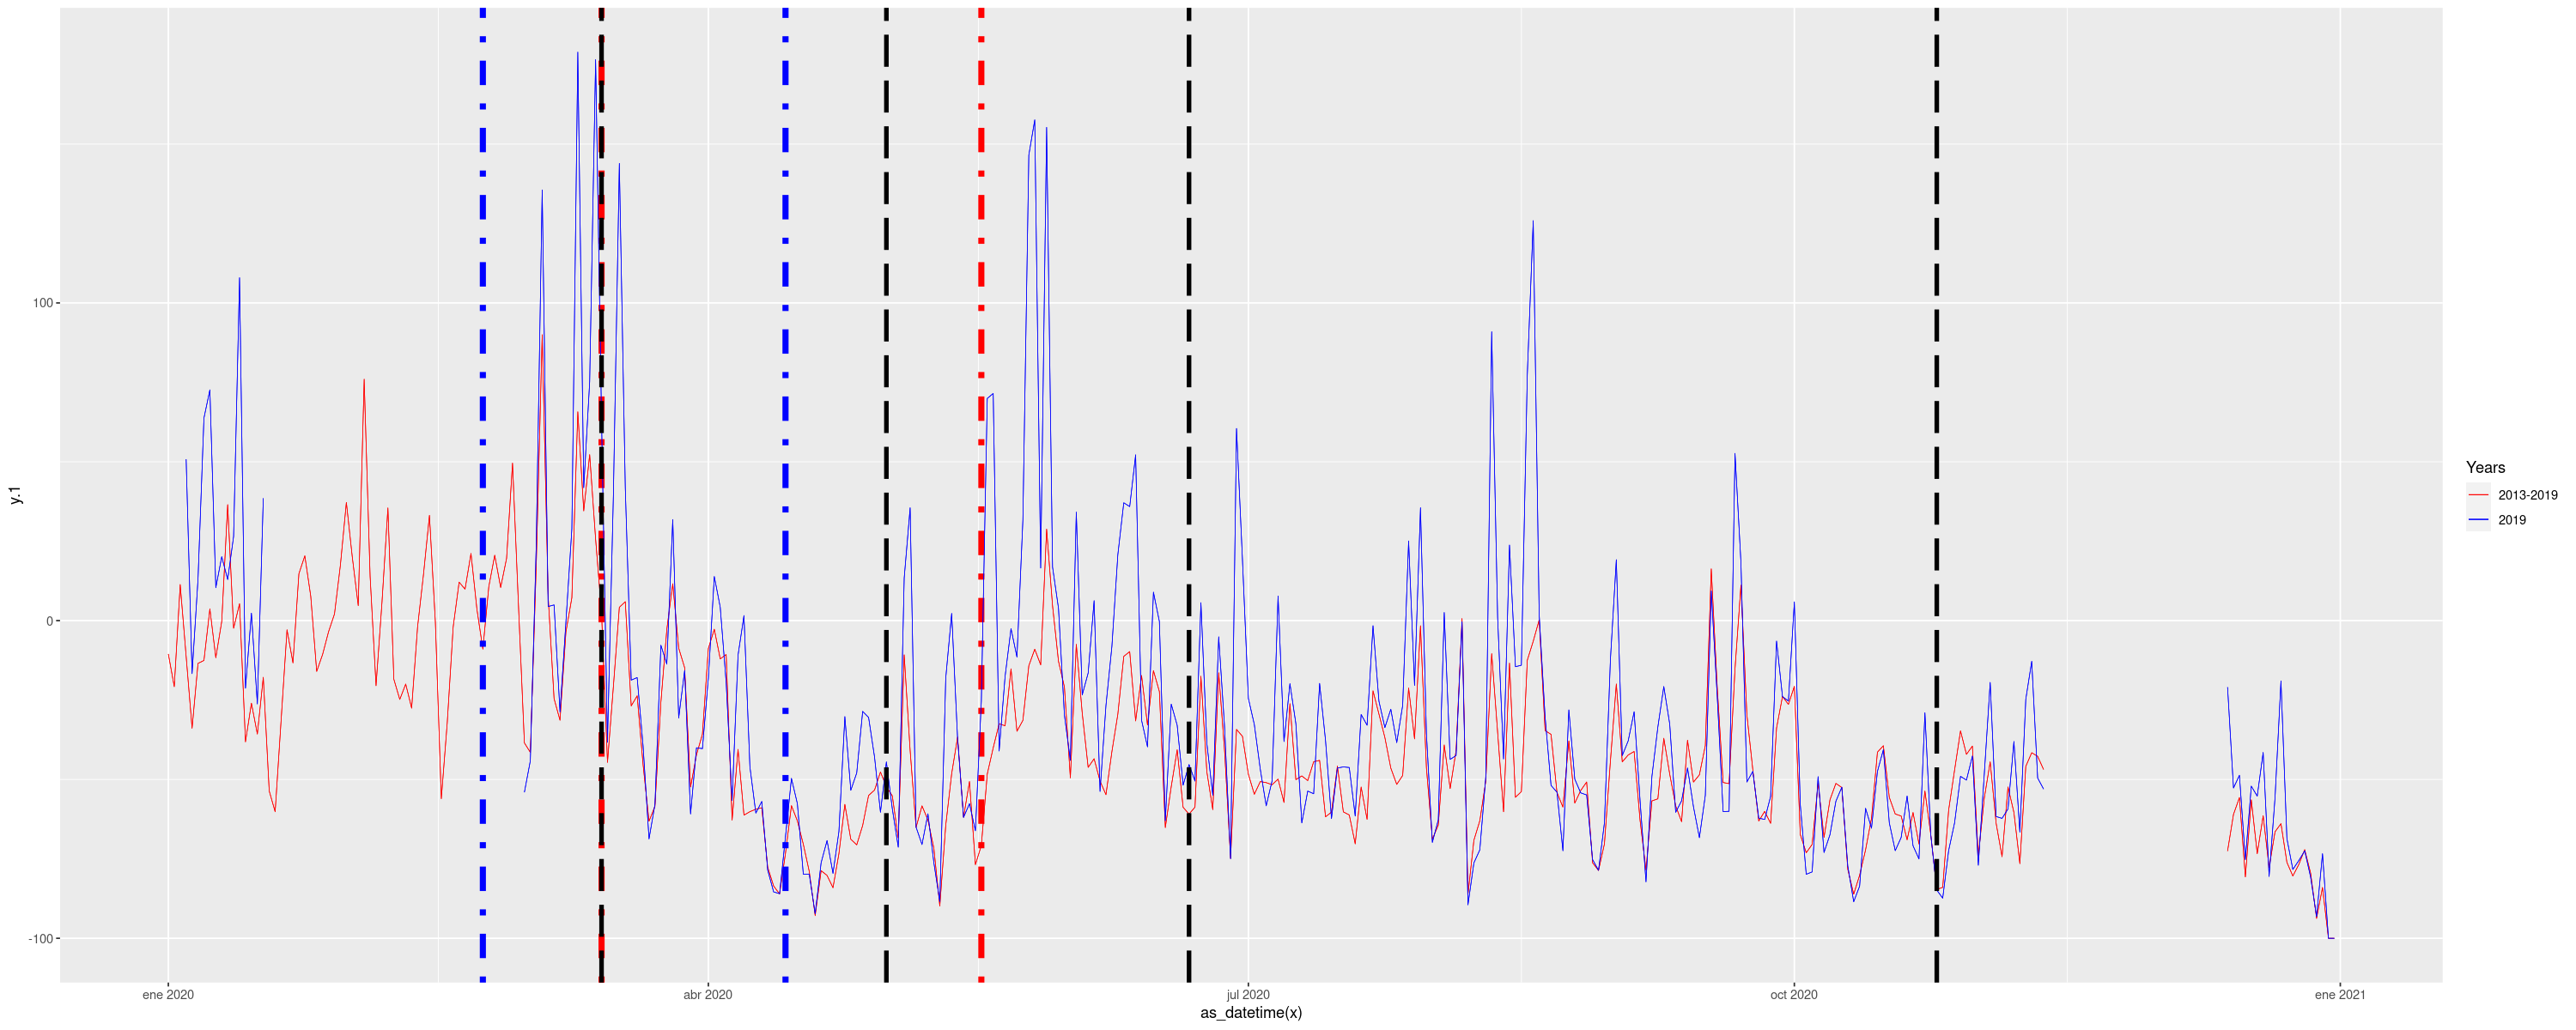

In [17]:
plot <- ggplot(data=var, aes(x=as_datetime(x))) + 
        scale_color_manual(name = "Years", values = c("2013-2019" = "red",
                                                      "2019" = "blue"))
for (k in 1:(length(new.breaks.1))) {
    plot <- plot + geom_line(aes(y=y.1, color="2013-2019"), size=0.2)
    plot <- plot + geom_vline(xintercept = var$x[new.breaks.1[k]], 
                              linetype=4, color = "red", size=2)
}
                                 
for (k in 1:(length(new.breaks.2))) {
    plot <- plot + geom_line(aes(y=y.2, color="2019"), size=0.2)
    plot <- plot + geom_vline(xintercept = var$x[new.breaks.2[k]], 
                              linetype=4, color = "blue", size=2)
}

for (k in 1:(length(periods))) {
    plot <- plot + geom_vline(xintercept = as.numeric(periods[k]), 
                              linetype=5, color = "black", size=1.5)
}

plot 

# Obtain Breakpoints from Air Quality data

In [18]:
a <- data.frame(y=data.all$"2020",
                x=as.numeric(data.all$date)
               )

## Using `segmented` package

In [19]:
suppressMessages(library(segmented))

my.seg <- segmented(lm(y ~ x + 1, data=a), 
                      seg.Z = ~ x,
                      psi = list(x = periods)
                     )

## Using `strucchange` package

In [20]:
suppressMessages(library(strucchange))

my.other.seg <- breakpoints(y ~ x + 1, 
                            h = 0.15, 
                            breaks = 5,
                            data = a)
new.breaks <- as_datetime(my.other.seg$breakpoints)

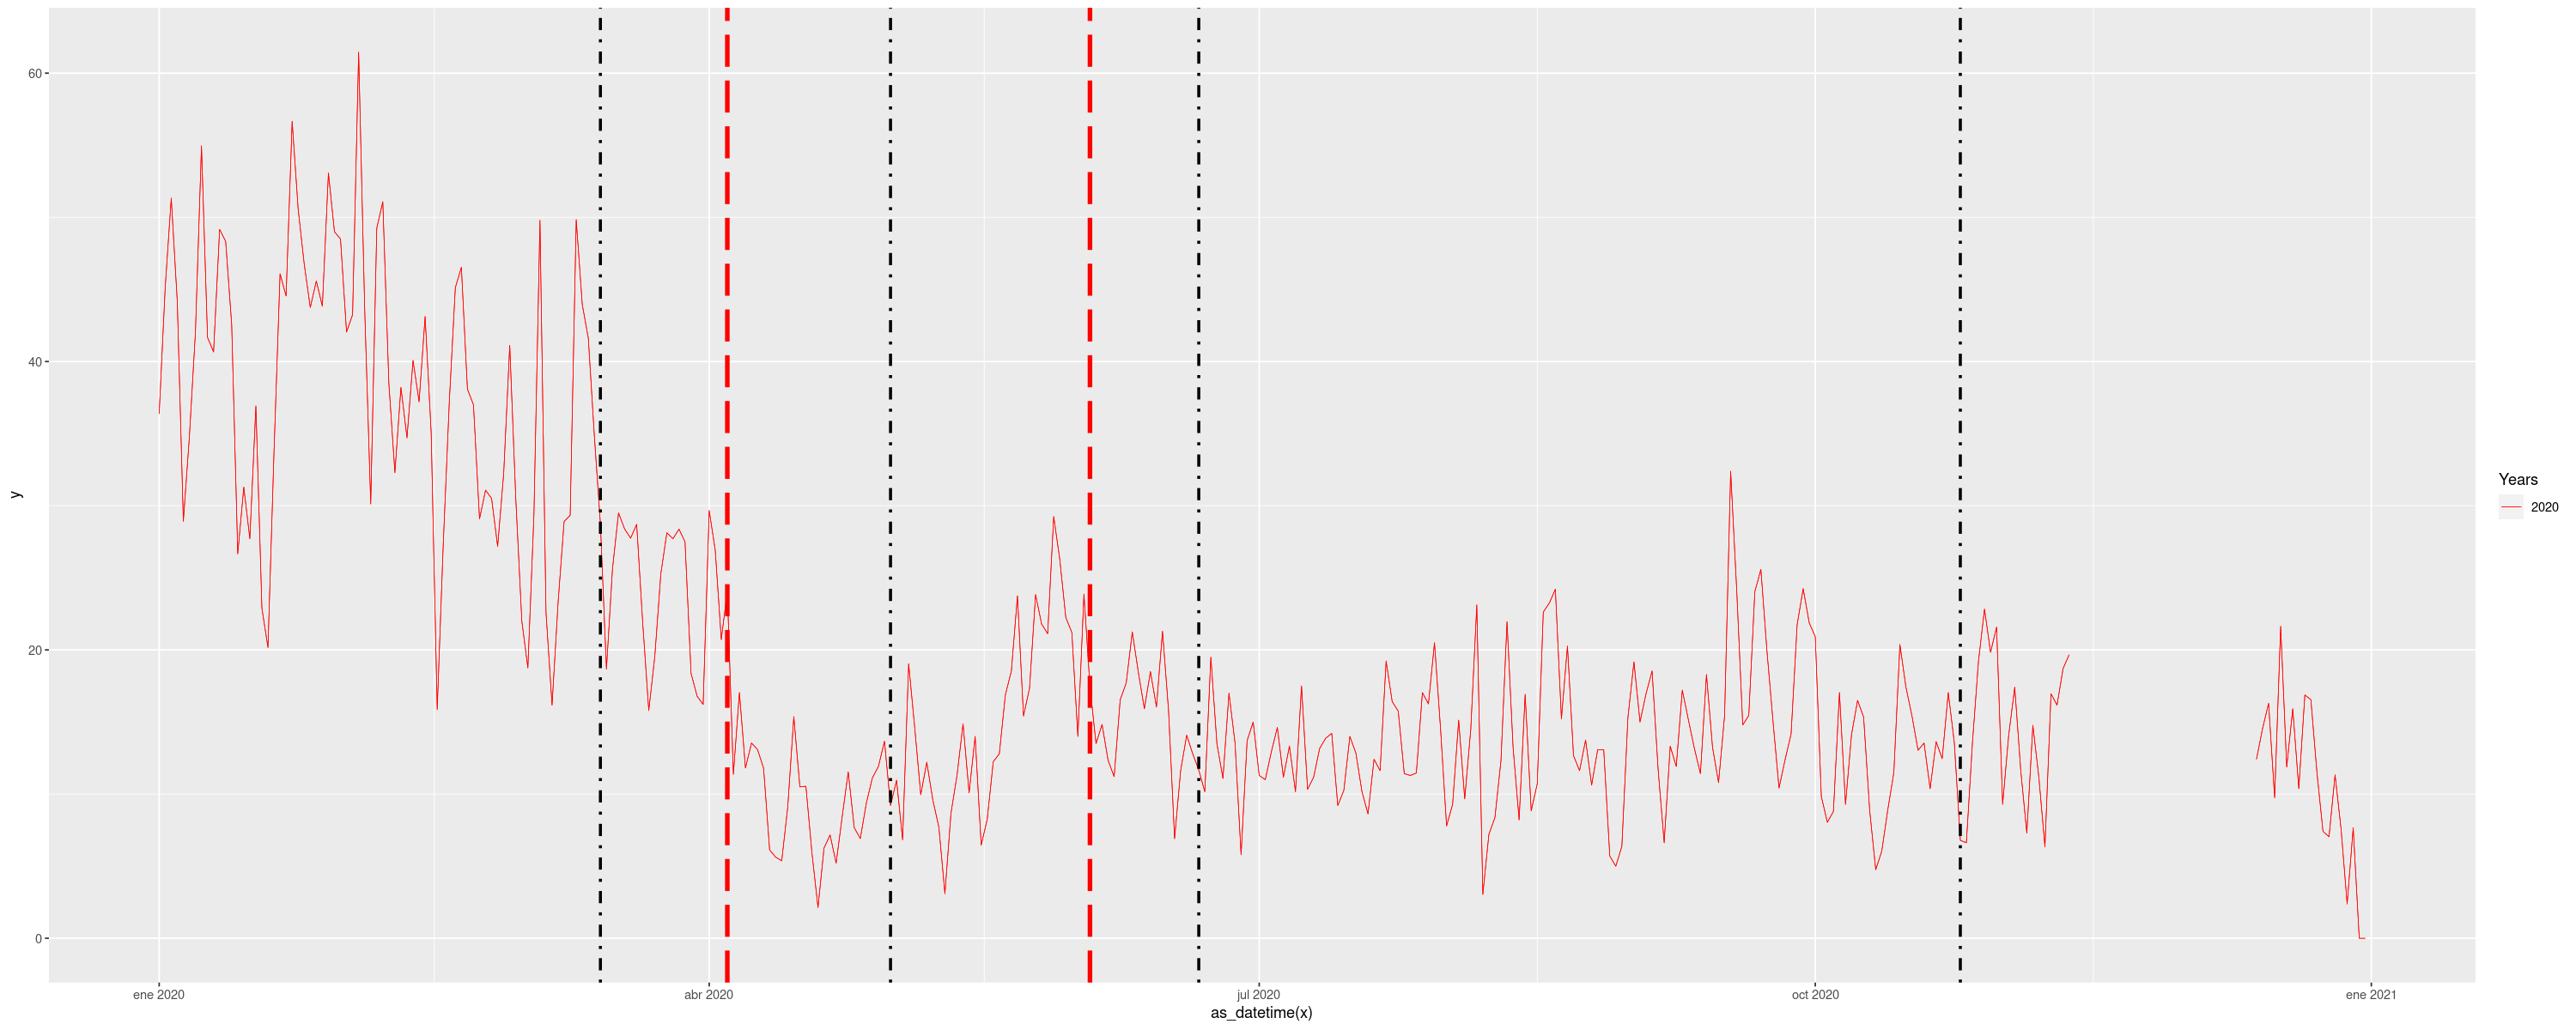

In [21]:
plot <- ggplot(data=a, aes(x=as_datetime(x))) + 
        scale_color_manual(name = "Years", values = c("2020" = "red"))

for (k in 1:(length(new.breaks))) {
    plot <- plot + geom_line(aes(y=y, color="2020"), size=0.2)
    plot <- plot + geom_vline(xintercept = var$x[new.breaks[k]], 
                              linetype=5, color = "red", size=1.5)
}

for (k in 1:(length(periods))) {
    plot <- plot + geom_vline(xintercept = as.numeric(periods[k]), 
                              linetype=4, color = "black", size=1)
}

plot

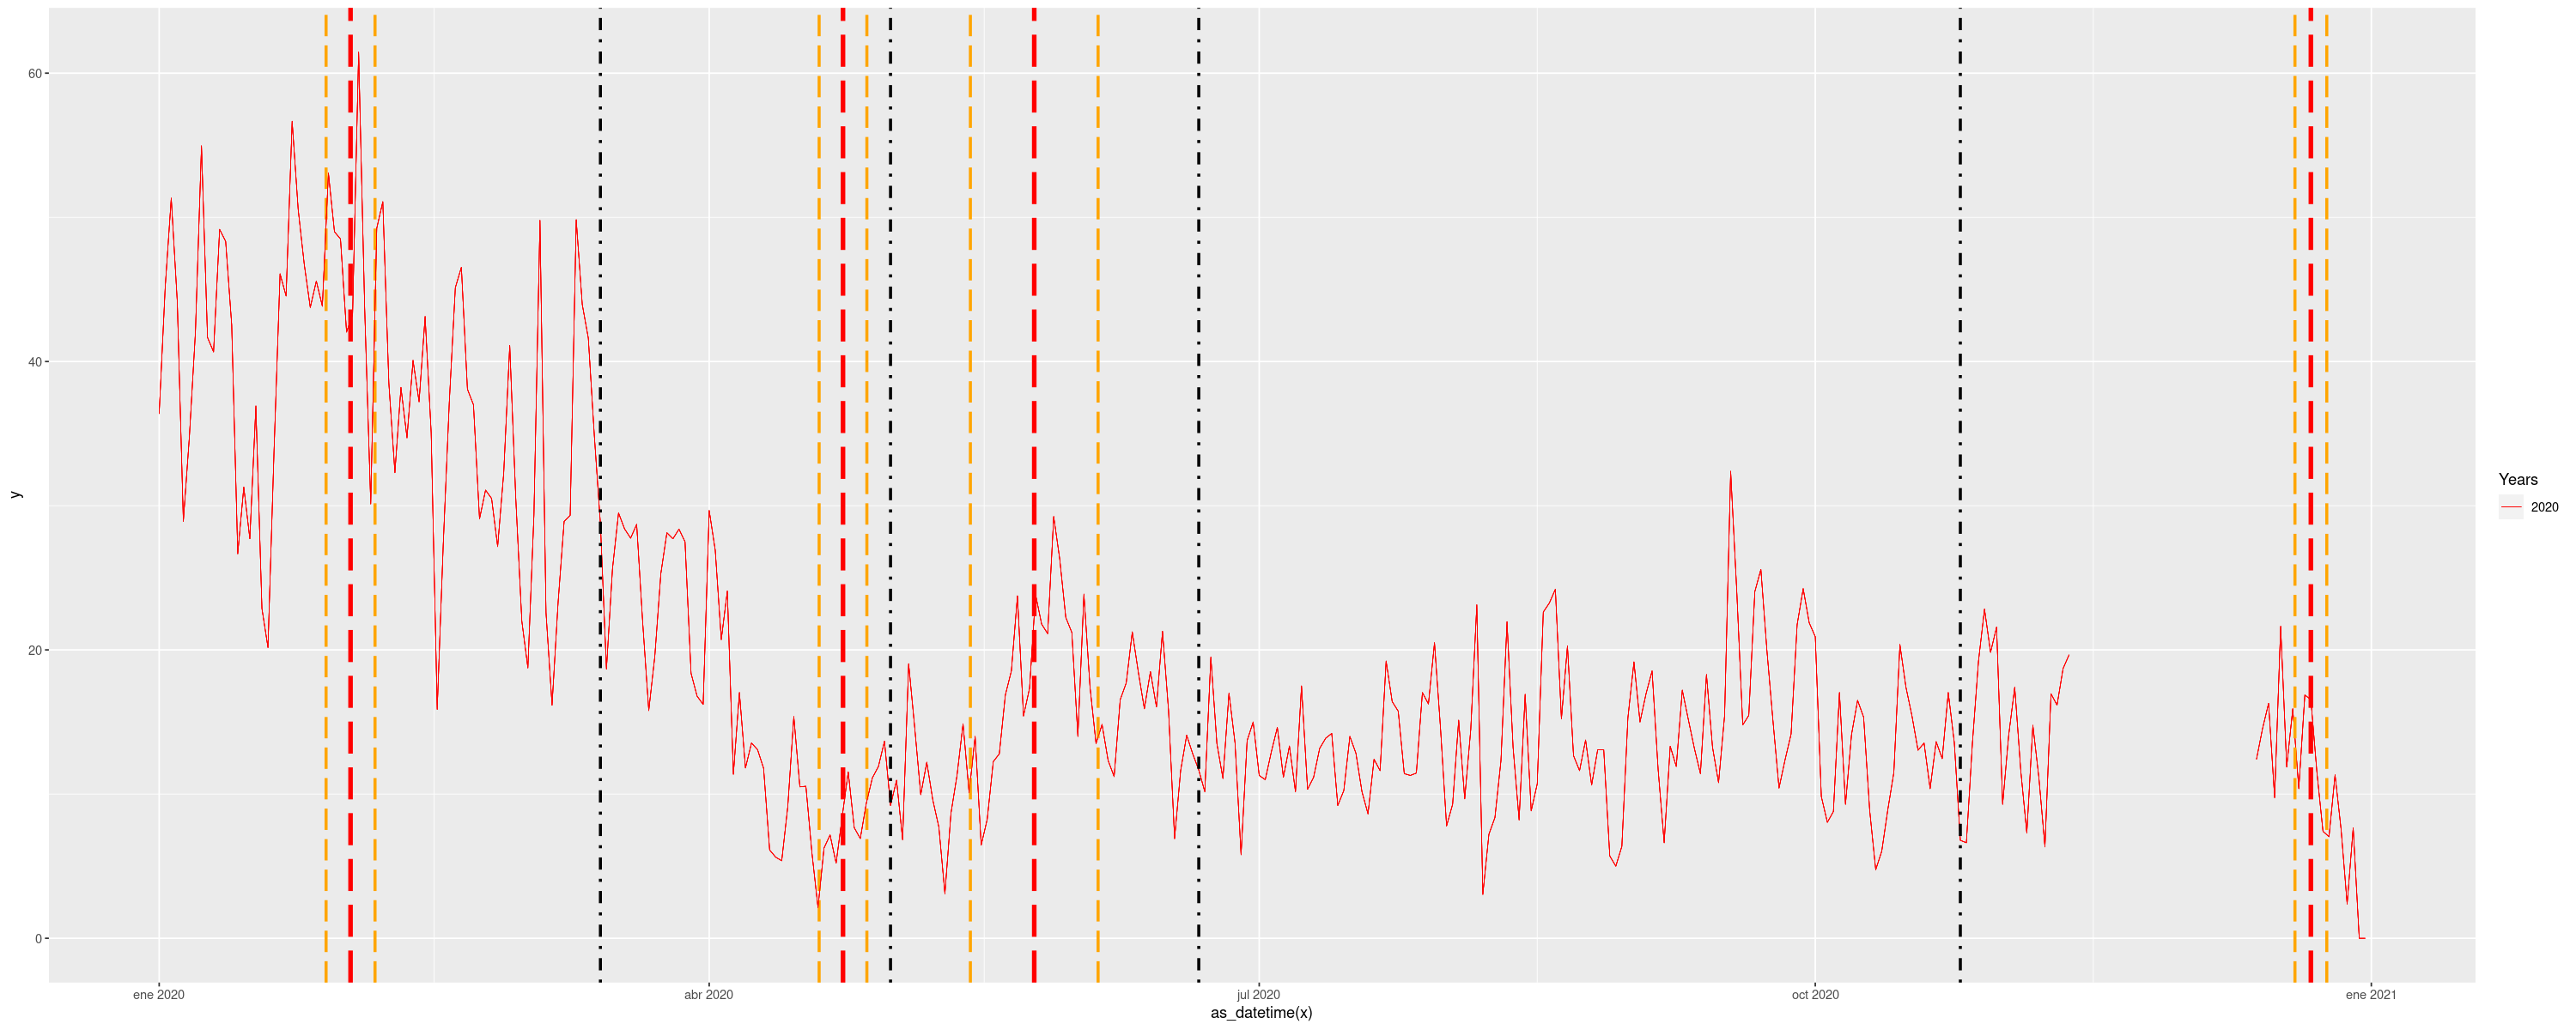

In [22]:
plot <- ggplot(data=a, aes(x=as_datetime(x)))+ 
    scale_color_manual(name = "Years", 
                       values = c("2020" = "red"))

for (k in 1:(nrow(my.seg$psi))) {
    plot <- plot + geom_line(aes(y=y, color="2020"), size=0.2)
    
    plot <- plot + geom_vline(xintercept = my.seg$psi[k,"Est."], 
                              linetype=5, color = "red", size=1.5)
    plot <- plot + geom_vline(xintercept = my.seg$psi[k,"Est."] - my.seg$psi[k,"St.Err"], 
                              linetype=5, color = "orange", size=1)
    plot <- plot + geom_vline(xintercept = my.seg$psi[k,"Est."] + my.seg$psi[k,"St.Err"], 
                              linetype=5, color = "orange", size=1)
}

for (k in 1:(length(periods))) {
    plot <- plot + geom_vline(xintercept = as.numeric(periods[k]), 
                              linetype=4, color = "black", size=1)
}

plot